In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

from amftrack.pipeline.launching.run_super import (
    run_launcher,
    directory_scratch,
    directory_project,
    directory_project,
    run_parallel_stitch,
    run_parallel_transfer,
)
import os
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    update_analysis_info,
    get_analysis_info,
    get_current_folders,
    get_folders_by_plate_id,
)

from time import time_ns
from amftrack.util.dbx import (
    upload_folders,
    load_dbx,
    download,
    get_dropbox_folders_prince,
)
from datetime import datetime
from amftrack.pipeline.launching.run_super import (
    run_parallel,
    directory_scratch,
    directory_project,
    run_parallel_stitch,
)
from amftrack.util.dbx import read_saved_dropbox_state, get_dropbox_folders_prince
import sys
import os

from amftrack.util.sys import get_dirname, temp_path
import pandas as pd
import ast
from scipy import sparse
import scipy.io as sio
import cv2
import imageio.v2 as imageio
import numpy as np
import scipy.sparse
import os
from time import time
from amftrack.pipeline.functions.image_processing.extract_skel import (
    extract_skel_new_prince,
    run_back_sub,
    bowler_hat,
)

from amftrack.util.sys import get_dates_datetime, get_dirname
import shutil
import matplotlib.pyplot as plt
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    save_graphs,
    load_graphs,
    Edge,
    Node,
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    reconstruct_image_from_general,
    plot_full,
    plot_edge_color_value,
)
from matplotlib import cm
import networkx as nx

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
directory_targ = directory_project
directory_targ = directory_targ + "fig1/"

In [3]:
update_plate_info(directory_targ, local=True)
all_folders = get_current_folders(directory_targ, local=True)

analysed:   0%|          | 0/38 [00:00<?, ?it/s]

In [4]:
len(all_folders)

38

In [5]:
folders = all_folders.loc[all_folders["/Analysis/nx_graph_pruned_width.p"] == True]
len(folders), len(all_folders)

(38, 38)

In [4]:
plates = all_folders["unique_id"].unique()
results = {}
for plate in plates:
    folders = all_folders.loc[all_folders["unique_id"] == plate]
    folders = folders.loc[folders["/Analysis/nx_graph_pruned_width.p"] == True]
    folders = folders.sort_values(by="datetime")

    exp = Experiment(directory_targ)
    i = 0
    exp.load(folders.iloc[i : i + 1], suffix="_width")
    for t in range(exp.ts):
        exp.load_tile_information(t)
    G = exp.nx_graph[t]
    components = nx.connected_components(G)

    # Find the largest connected component
    largest_component = max(components, key=len)

    # Create a new graph representing the largest connected component
    largest_component_graph = G.subgraph(largest_component)
    exp.nx_graph[t] = largest_component_graph
    edges = get_all_edges(exp, t)
    lengths = [edge.length_um(t) for edge in edges]
    widths = [edge.width(t) for edge in edges]
    folders = all_folders.loc[all_folders["unique_id"] == plate]
    strain = folders["strain"].value_counts().idxmax()
    if np.max(widths) != 40:
        results[plate] = edges, lengths, widths, [strain] * len(edges)
    else:
        print(plate)

2024-06-14 11:22:00
2023-10-07 20:34:00
2022-10-22 17:17:00
2022-10-10 02:21:00
2022-05-07 16:29:00
2023-01-08 07:49:00
2024-01-11 16:16:00
2023-01-23 08:06:00
2022-05-29 18:27:00
2022-05-14 04:25:00
2023-12-04 12:48:00
2023-03-22 18:24:00
2022-05-08 01:47:00
2023-01-18 06:13:00
2022-07-14 12:48:00
2023-01-14 20:34:00
2023-03-05 13:10:00
2022-06-22 22:45:00
2023-01-11 11:55:00
2022-05-25 19:47:00
2022-04-23 19:40:00
2022-03-29 00:42:00
2022-12-12 12:33:00
2022-05-09 14:09:00
2022-05-13 13:52:00
2022-12-27 10:42:00
2023-03-29 14:20:00
2022-12-04 20:54:00
2023-01-11 22:10:00
2024-06-14 09:50:00
2022-07-14 16:19:00
2023-09-30 02:18:00
2022-05-05 17:32:00
2022-12-13 17:03:00
2022-12-02 06:42:00
2023-03-21 07:03:00
2023-01-18 02:04:00
2022-12-13 15:09:00


In [5]:
data = []

# Iterate over the results to create rows for the DataFrame
for plate, (edges, lengths, widths, strains) in results.items():
    for edge, length, width, strain in zip(edges, lengths, widths, strains):
        data.append(
            {
                "plate": plate,
                "edge": edge,
                "length": length,
                "width": width,
                "strain": strain,
            }
        )

# Create DataFrame from the list
df_results = pd.DataFrame(data)

In [6]:
df_results["radius"] = df_results["width"] / 2
df_results["weight"] = df_results["radius"] ** 2 * df_results["length"]
# df_results['weight'] = df_results['length']
df_results.loc[df_results["strain"] == "'A5sp3'", "strain"] = "'A5'"
df_results["strain"].unique()

array(["'C3'", "'A5'", "'C2'", "'Agg'", "'Clarum'"], dtype=object)

In [10]:
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 3.9 MB/s eta 0:00:00ta 0:00:01

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip


In [7]:
import seaborn as sns

plt.style.use("presentation.mplstyle")
import logging

# Set the logging level to WARNING to suppress INFO and DEBUG messages
logging.basicConfig(level=logging.WARNING)

In [8]:
palette = {
    "'C2'": (0.17058823529411765, 0.4946558433997788, 0.9667184042691874),
    "'A5'": (0.16666666666666663, 0.8660254037844386, 0.8660254037844387),
    "'Agg'": (0.503921568627451, 0.9999810273487268, 0.7049255469061472),
    "'Clarum'": (0.8333333333333333, 0.8660254037844387, 0.5000000000000001),
    "'C3'": (1.0, 0.4946558433997788, 0.2558427775944356),
}

In [ ]:
# weighted_mean = np.sqrt((strain_data['radius']**2 * strain_data['length']).sum() / strain_data['length'].sum())
# weighted_mean

<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\m'
/scratch-local/cbisot/ipykernel_3043942/2473663976.py:37: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel("radius ($\mu m$)")


'C3' 2.5885130142583845
'A5' 2.888884010751932
'C2' 2.720950589718575
'Agg' 2.4295535462800437
'Clarum' 2.965359246017242


[Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4'),
 Text(5, 0, '5'),
 Text(6, 0, '6'),
 Text(7, 0, '7')]

2024-06-23 15:30:21,358-[WARNING]- matplotlib.font_manager:1365 -> findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
2024-06-23 15:30:21,359-[WARNING]- matplotlib.font_manager:1365 -> findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
2024-06-23 15:30:21,361-[WARNING]- matplotlib.font_manager:1365 -> findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
2024-06-23 15:30:21,362-[WARNING]- matplotlib.font_manager:1365 -> findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
2024-06-23 15:30:21,363-[WARNING]- matplotlib.font_manager:1365 -> findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
2024-06-23 15:30:21,364-[WARNING]- matplotlib.font_manager:1365 -> findfont: Generic family 'sans-serif' not found because none of the follo

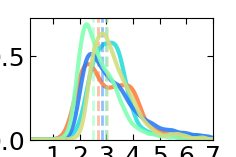

In [12]:
plt.close("all")
from matplotlib.ticker import FuncFormatter

cm = 1 / 2.54  # centimeters in inches

fig, ax = plt.subplots(figsize=(6 * cm, 4 * cm))
select = df_results[df_results["width"] > 0.1]
select = select[select["width"] <= 14]

# sns.histplot(select,x = 'radius',hue="strain",kde = True, weights = "weight",stat="density",bins = 30, common_norm=False,palette= palette,fill=False)
for strain in select["strain"].unique():
    strain_data = select[select["strain"] == strain]
    weighted_mean = (strain_data["radius"] * strain_data["weight"]).sum() / strain_data[
        "weight"
    ].sum()
    weighted_mean = (strain_data["radius"] * strain_data["length"]).sum()/ strain_data["length"].sum()
    print(strain,weighted_mean)
    weighted_mean = np.sqrt(
        (strain_data["radius"] ** 2 * strain_data["length"]).sum()
        / strain_data["length"].sum()
    )

    ax.axvline(
        weighted_mean, color=palette[strain], linestyle="--", linewidth=2, alpha=0.5
    )
    # print(strain, len(strain_data["plate"].unique()),weighted_mean)
    
    sns.kdeplot(
        strain_data,
        x="radius",
        ax=ax,
        label=strain,
        weights="weight",
        color=palette[strain],
        alpha=0.9,
    )
ax.set_xlabel("radius ($\mu m$)")
ax.set_ylabel("density")
# ax.set_yscale('log')
# ax.set_xscale('log')

# ax.set_ylim(1e-2,1)
ax.set_xlim(0.1, 7)

ax.set_xticks([1, 2, 3, 4, 5, 6, 7])
ax.set_xticklabels(["1", "2", "3", "4", "5", "6", "7"])
# def format_fn(tick_val, tick_pos):
#     if int(tick_val) in [1,2, 4, 6, 7]:
#         return str(int(tick_val))
#     else:
#         return ''

# # Apply the formatter to the x-axis
# ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
# plt.savefig(os.path.join('figures','Figure1D2.pdf'), transparent=True, bbox_inches='tight')

In [ ]:
veéefer

In [ ]:
plt.close("all")
from matplotlib.ticker import FuncFormatter

cm = 1 / 2.54  # centimeters in inches

fig, ax = plt.subplots(figsize=(6 * cm, 4 * cm))
select = df_results[df_results["width"] > 0.1]
select = select[select["width"] <= 14]

# sns.histplot(select,x = 'radius',hue="strain",kde = True, weights = "weight",stat="density",bins = 30, common_norm=False,palette= palette,fill=False)
for strain in select["strain"].unique():
    strain_data = select[select["strain"] == strain]
    weighted_mean = (strain_data["radius"] * strain_data["weight"]).sum() / strain_data[
        "weight"
    ].sum()
    weighted_mean = np.sqrt(
        (strain_data["radius"] ** 2 * strain_data["length"]).sum()
        / strain_data["length"].sum()
    )

    ax.axvline(
        weighted_mean, color=palette[strain], linestyle="--", linewidth=2, alpha=0.5
    )
    sns.kdeplot(
        strain_data,
        x="radius",
        ax=ax,
        label=strain,
        weights="weight",
        color=palette[strain],
        alpha=0.9,
    )
ax.set_xlabel("radius ($\mu m$)")
ax.set_ylabel("density")
ax.set_yscale("log")
# ax.set_xscale('log')

ax.set_ylim(1e-2, 1)
# ax.set_xlim(0.1,7)

# ax.set_xticks([1,2, 3, 4,5,6, 7])
# ax.set_xticklabels(['1','2', '3', '4','5','6', '7'])
# def format_fn(tick_val, tick_pos):
#     if int(tick_val) in [1,2, 4, 6, 7]:
#         return str(int(tick_val))
#     else:
#         return ''

# # Apply the formatter to the x-axis
# ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
# plt.savefig(os.path.join('figures','Figure1D2.pdf'), transparent=True, bbox_inches='tight')

In [ ]:
plates

In [ ]:
plate = "472_20221003"
folders = all_folders.loc[all_folders["unique_id"] == plate]
folders = folders.loc[folders["/Analysis/nx_graph_pruned_width.p"] == True]
folders = folders.sort_values(by="datetime")

exp = Experiment(directory_targ)
i = 0
exp.load(folders.iloc[i : i + 1], suffix="_width")
for t in range(exp.ts):
    exp.load_tile_information(t)
G = exp.nx_graph[t]
components = nx.connected_components(G)

# Find the largest connected component
largest_component = max(components, key=len)

# Create a new graph representing the largest connected component
largest_component_graph = G.subgraph(largest_component)
exp.nx_graph[t] = largest_component_graph
edges = get_all_edges(exp, t)

In [ ]:
len(edges)

In [ ]:
edges_choice = np.random.choice(edges, size=1000, replace=False)

In [ ]:
from tqdm.notebook import tqdm
from amftrack.pipeline.functions.image_processing.extract_width_fun import (
    compute_edge_width_profile,
)

resolution = 50
TARGET_LENGTH = 120
edge_width = {}
for edge_exp in tqdm(edges_choice):
    if len(edge_exp.pixel_list(t)) > 2 * resolution:
        prediction = compute_edge_width_profile(
            exp,
            t,
            edge_exp,
            resolution=resolution,
            offset=8,
            step=6,
            target_length=TARGET_LENGTH,
        )
        median = np.median(prediction)
        edge_width[edge_exp] = median
    else:
        edge_width[edge_exp] = 0

In [ ]:
widths = [edge.width(t) for edge in edges_choice if np.sqrt(edge_width[edge]) > 0]
widths2 = [
    np.sqrt(edge_width[edge]) for edge in edges_choice if np.sqrt(edge_width[edge]) > 0
]

In [ ]:
fig, ax = plt.subplots()
ax.scatter(widths, widths2)

In [ ]:
path_figure = r"/mnt/c/Users/coren/Documents/PhD/paper/PandC/Fig1"

cm = 1 / 2.54  # centimeters in inches
y_test, y_predict = np.array(widths), np.array(widths2)
fig, ax = plt.subplots(figsize=(5.2 * cm, 5.2 * cm))
ax.scatter(y_test / 2, y_predict / 2 - y_test / 2, s=3, alpha=0.2)
ax.hlines(0, 0, 8, color="black", linestyle="dashed")

ax.set_xlabel("$r_{real}$ ($\mu m$)")
ax.set_ylabel("$r_{predicted}-r_{real}$ ($\mu m$)")
# ax.set_xlim()
ax.set_ylim(-1 * np.std(y_test), 1 * np.std(y_test))
residuals = y_predict / 2 - y_test / 2
n = 12

# New code for evenly spaced groups
min_y_test, max_y_test = np.min(y_test) / 2, np.max(y_test) / 2
interval_length = (max_y_test - min_y_test) / n
group_means = []
group_stds = []  # For uncertainties

for i in range(n):
    start = min_y_test + i * interval_length
    end = start + interval_length
    indices = np.where((y_test / 2 >= start) & (y_test / 2 < end))
    if len(indices[0]) > 2:
        # mean_y_test = np.nanmean(y_test[indices] / 2)
        mean_residual = np.nanmean(residuals[indices])
        mean_y_test = (start + end) / 2
        mean_y_test = start

        std_residual = np.nanstd(
            residuals[indices]
        )  # Standard deviation for uncertainty
        group_means.append((mean_y_test, mean_residual))
        group_stds.append(std_residual)
        print(end)
    # break
group_means = np.array(group_means)
# Plotting the mean
ax.plot(group_means[:, 0], group_means[:, 1], color="red", label="Mean Residual")

# Adding shaded uncertainty areas
ax.fill_between(
    group_means[:, 0],
    group_means[:, 1] - group_stds,
    group_means[:, 1] + group_stds,
    color="red",
    alpha=0.2,
)
# plt.savefig(os.path.join(path_figure,'residuals.pdf'), transparent=True, bbox_inches='tight')
ax.set_xlim(0, 7)